In [1]:
from traffic.core import Traffic

In [2]:
t_5_10 = Traffic.from_file("../data/samples/t_5_10_dep_arr.pkl")

In [3]:
traf = Traffic.from_file("../data/intermediate/taxi_zurich_2019_takeoff.pkl")

In [6]:
filter_dict = dict(compute_track_unwrapped=21, compute_track=21, compute_gs=21)
f = t_5_10["SWR134A_16058"].first("20T").cumulative_distance().unwrap(["compute_track"])
f_filtered = f.filter(**filter_dict).diff("compute_track_unwrapped")

In [5]:
from typing import (
    TYPE_CHECKING,
    Iterable,
    Iterator,
    List,
    Optional,
    Sequence,
    Union,
    cast,
)
def pushback(
    self,
    airport,
    filter_dict=dict(
        compute_track_unwrapped=21, compute_track=21, compute_gs=21
    ),
    track_threshold: float = 90,
):
    """
    Returns the pushback part of the trajectory on ground.

    The method identifies the start of the movement, the parking_position
    and the moment the aircraft suddenly changes direction the computed
    track angle.

    .. warning::

        The method has poor performance when trajectory point on ground are
        lacking. This is often the case for data recorded from locations far
        from the airport.

    """

    # Donne les fonctions possibles sur un flight object
    self = cast("Flight", self)

    _airport = airports[airport] if isinstance(airport, str) else airport
    if _airport is None or _airport.runways.shape.is_empty:
        return None

    within_airport = self.inside_bbox(_airport)
    if within_airport is None:
        return None

    parking_position = within_airport.on_parking_position(_airport).max()
    if parking_position is None:
        return None

    after_parking = within_airport.after(parking_position.start)
    assert after_parking is not None

    in_movement = after_parking.after(after_parking.moving(filter_dict=dict(compute_gs=31)).start)

    if in_movement is None:
        return None

    direction_change = (
        # trim the first few seconds to avoid annoying first spike
        in_movement.first("7T")
        .last("6T30s")
        #.resample('5s')
        .cumulative_distance()
        .unwrap(["compute_track"])
        .filter(**filter_dict)
        .diff("compute_track_unwrapped")
        .query(f"compute_track_unwrapped_diff.abs() > {track_threshold}")
    )

    if direction_change is None:
        return None

    return in_movement.before(direction_change.start).assign(
        parking_position=parking_position.parking_position_max
    )

In [177]:
f.map_leaflet(zoom=13, highlight=dict(red=lambda x: x.pushback("LSZH")))

Map(center=[47.45629118693077, 8.560667564318729], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [178]:
f.pushback2 = types.MethodType(pushback, f)
m=f.map_leaflet(zoom=13)
m.add_layer(f.pushback2('LSZH').leaflet(color='red'))
m

Map(center=[47.45629118693077, 8.560667564318729], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [144]:
f.moving(filter_dict=dict(compute_gs=31)).map_leaflet(zoom=13, highlight=dict(red=lambda x: x.pushback("LSZH")))

Map(center=[47.45559451143973, 8.560201533953302], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [145]:
f2 = t_5_10['SWR646_12082'].first('160T')
f2.map_leaflet(zoom=13)

Map(center=[47.454960653282285, 8.559853756969323], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
f2.

In [146]:
filter_dict=dict(
    compute_track_unwrapped=21, compute_track=21, compute_gs=21
)
track_threshold: float = 90

In [147]:
_airport=airports['LSZH']
within_airport = f2.inside_bbox(_airport)
if within_airport is None:
    print("none")

parking_position = within_airport.on_parking_position(_airport).max()
if parking_position is None:
    print("none1")

after_parking = within_airport.after(parking_position.start)
assert after_parking is not None

in_movement = after_parking.moving()

if in_movement is None:
    print("none2")

direction_change = (
    # trim the first few seconds to avoid annoying first spike
    in_movement.first("5T")
    .last("4T30s")
    .cumulative_distance()
    .unwrap(["compute_track"])
    .filter(**filter_dict)
    .diff("compute_track_unwrapped")
    .query(f"compute_track_unwrapped_diff.abs() > {track_threshold}")
)

In [151]:
speed_threshold: float = 2,
time_threshold: str = "30s",
filter_dict=dict(compute_gs=3),
resample_rule: str = "5s",

In [152]:
in_movement.moving(filter_dict=dict(compute_gs=31)).map_leaflet(zoom=13)

Map(center=[47.45757545922001, 8.561018058478185], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [153]:
in_movement.pushback2 = types.MethodType(pushback, in_movement)

In [154]:
in_movement.pushback2('LSZH').map_leaflet(zoom=13)

Map(center=[47.452798960868265, 8.559699729504327], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [155]:
import types
f3.pushback2 = types.MethodType(pushback, f3)

In [156]:
f3 = traf['EDW146Z_5711']
debug_moving(f3, 15)

orig


Map(center=[47.45749668488147, 8.558688218483015], controls=(ZoomControl(options=['position', 'zoom_in_text', …

moving


Map(center=[47.45754458945182, 8.558716317211065], controls=(ZoomControl(options=['position', 'zoom_in_text', …

moving filtered


Map(center=[47.45961840955633, 8.558536056779388], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Pushbacl


Map(center=[47.4524209368501, 8.559219822755159], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [158]:
f3 = traf = ['EDW146Z_5711']
pbstop = f3.pushback2('LSZH').stop

f3.resample('7s').map_leaflet(zoom=13, highlight=dict(red=lambda x : x.after(pbstop).slow_taxi()))

In [159]:
f4 = traf['AUA568_3375']
debug_moving(f4)

orig


Map(center=[47.455856023453116, 8.557537147094838], controls=(ZoomControl(options=['position', 'zoom_in_text',…

moving


Map(center=[47.455764340415634, 8.557620927269445], controls=(ZoomControl(options=['position', 'zoom_in_text',…

moving filtered


Map(center=[47.455973851511494, 8.557585066874065], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Pushbacl


Map(center=[47.45448386291414, 8.557943305841656], controls=(ZoomControl(options=['position', 'zoom_in_text', …

# pb en {

In [133]:
f5=traf['AUA568_3890']
#f5.moving(filter_dict=dict(compute_gs=(13,51))).map_leaflet(zoom=13)

In [134]:
debug_moving(f5)

orig


Map(center=[47.456115114103056, 8.556741417653202], controls=(ZoomControl(options=['position', 'zoom_in_text',…

moving


Map(center=[47.4602901271404, 8.55928315068095], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

moving filtered


Map(center=[47.4602901271404, 8.55928315068095], controls=(ZoomControl(options=['position', 'zoom_in_text', 'z…

Pushbacl


Map(center=[47.45487033832954, 8.555837395043577], controls=(ZoomControl(options=['position', 'zoom_in_text', …

# For pb with bad trimmming

In [104]:
f6 = traf['SWR1958_11255']
f6.map_leaflet(zoom=13)

/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)


Map(center=[47.45390358255975, 8.555573714883263], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [105]:
def debug_moving(f, kerval=31):
    print('orig')
    display(f.map_leaflet(zoom=13))
    print('moving')
    display(f.moving().map_leaflet(zoom=13))
    print('moving filtered')
    display(f.moving(filter_dict=dict(compute_gs=kerval)).map_leaflet(zoom=13))
    print('Pushbacl')
    f.pushback2 = types.MethodType(pushback, f)
    display(f.pushback2('LSZH').map_leaflet(zoom=13))

In [106]:
debug_moving(f6)

orig


Map(center=[47.45390358255975, 8.555573714883263], controls=(ZoomControl(options=['position', 'zoom_in_text', …

moving


Map(center=[47.45391042477364, 8.555657864728452], controls=(ZoomControl(options=['position', 'zoom_in_text', …

moving filtered


Map(center=[47.45505707450508, 8.55204479456894], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

Pushbacl


NameError: name 'types' is not defined

In [ ]:
f6.map_leaflet(zoom=13)

In [163]:
f6_1=f6.moving(filter_dict=dict(compute_gs=31))

In [165]:
f6_1.first("7T").last("6T30s").cumulative_distance().unwrap(["compute_track"]).filter(**filter_dict).diff("compute_track_unwrapped").query(f"compute_track_unwrapped_diff.abs() > {track_threshold}").map_leaflet(zoom=13)

SyntaxError: invalid syntax (<ipython-input-165-eeea0190f9f3>, line 2)

In [166]:
f6_2.map_leaflet(zoom=13)

Map(center=[47.45222591895841, 8.55609576233432], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [112]:
import altair as alt

In [107]:
f7 = traf['IBE3475_583']
debug_moving(f7, 15)

orig


Map(center=[47.44990640827678, 8.560796624211253], controls=(ZoomControl(options=['position', 'zoom_in_text', …

moving


Map(center=[47.45043564864948, 8.560501686927381], controls=(ZoomControl(options=['position', 'zoom_in_text', …

moving filtered


Map(center=[47.45252027458251, 8.559274693212567], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Pushbacl


NameError: name 'types' is not defined

In [6]:
import pandas as pd

In [7]:
dep_arr_df = pd.read_pickle("../data/processed/dep_arr_df10_meansifis.pkl")

In [19]:
tpb = Traffic.from_flights([f.before(f.pushback('LSZH').stop).cumulative_distance() for _,fid in dep_arr_df.query("first_movement_start.dt.day==7 & first_movement_start.dt.month==10 & end_pb==end_pb").iterrows() if (f:=traf[fid.flight_id]) is not None])

/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/t

In [20]:
len(tpb)

112

In [22]:
tpb = tpb.cumulative_distance().eval(desc="", max_workers=23)
tpb_dist_df = tpb.summary(['flight_id', 'cumdist_max'])

  0%|          | 0/112 [00:00<?, ?it/s]

<AxesSubplot:>

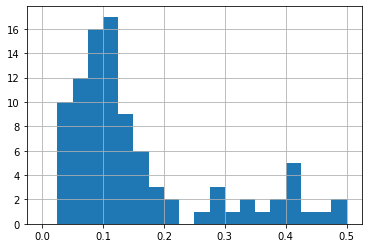

In [23]:
tpb_dist_df.cumdist_max.hist(bins=20, range=(0,0.5))

In [64]:
len(too_long_pb_traf)

39

In [24]:
too_long_pb_traf = Traffic.from_flights([f for f in tpb if f.cumdist_max>0.2])

In [63]:
too_long_pb_traf.map_leaflet(zoom=14)

Map(center=[47.458284299083836, 8.556414221733124], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [45]:
tpb_5_10 = Traffic.from_flights([f.before(f.pushback('LSZH').stop).cumulative_distance() if f.pushback('LSZH') is not None else None for _,fid in dep_arr_df.query("first_movement_start.dt.day==5 & first_movement_start.dt.month==10 & end_pb==end_pb").iterrows() if ((f:=traf[fid.flight_id]) is not None) ]).clean_invalid()

/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/t

In [46]:
len(tpb_5_10)

218

In [103]:
tpb_5_10pp = Traffic.from_flights([f.on_parking_position('LSZH').max() for f in tpb_5_10]).clean_invalid()
tpb_5_10pp

/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/t

ImportError: cannot import name 'Label' from 'pandas._typing' (/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/pandas/_typing.py)

               count
flight_id           
SWR109V_11228   7270
SWR137H_9787    5064
SWR33K_10249    4948
SWR786_12466    4414
IBE3475_583     4064
OTF6411_4441    3665
SWR159Q_10955   3379
SWR115J_11826   3369
SWR288Z_12064   3268
SWR31K_10981    2740

In [96]:
tpb_5_10.map_leaflet(zoom=13)

Map(center=[47.503424368727956, 8.392947544254344], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [48]:
#tpb = tpb.cumulative_distance().eval(desc="", max_workers=23)
tpb_dist_5_10_df = tpb_5_10.summary(['flight_id', 'cumdist_max'])

In [95]:
tpb_dist_5_10_df.sort_values('cumdist_max')

flight_id  cumdist_max
217   VLG58QZ_537     0.000000
83     QTR096_160     0.000000
143  SWR215U_7128     0.000000
74    LOT412_4838     0.000000
73    KLM58C_4643     0.000000
..            ...          ...
203  SXS4FA_19556     0.900488
0     AAL93_20327     1.009058
44    EDW420_6886     1.027273
37    EDW24_14993     2.101601
215  VJT796_19167   497.833781

[218 rows x 2 columns]

<AxesSubplot:>

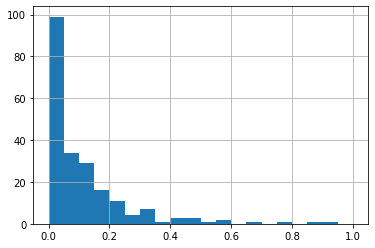

In [55]:
tpb_dist_5_10_df.cumdist_max.hist(bins=20, range=(0,1))

<AxesSubplot:>

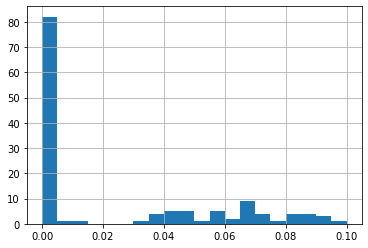

In [58]:
tpb_dist_5_10_df.cumdist_max.hist(bins=20, range=(0,0.1))

In [51]:
too_long_pb_5_10_traf = Traffic.from_flights([f for f in tpb_5_10 if f.cumdist_max>0.2])

In [59]:
too_short_pb_5_10_traf = Traffic.from_flights([f for f in tpb_5_10 if f.cumdist_max<0.02])

In [67]:
too_long_pb_5_10_traf.map_leaflet(zoom=14)

Map(center=[47.623793028562616, 7.9960637424629555], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [68]:
too_short_pb_5_10_traf.map_leaflet(zoom=14)

Map(center=[47.45244833178917, 8.558370233803707], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [62]:
too_short_pb_5_10_traf['SWR1710_7719'].cumulative_distance().cumdist_max#.map_leaflet(zoom=13)

0.0

/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)


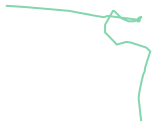

In [26]:
traf['EDW146Z_5711'].first("15T").pushback('LSZH')

In [34]:
dep_arr_df.loc[dep_arr_df.flight_id.duplicated()]

flight_id            on_runway_time taxi_holding_time  \
456    SWR982_14873 2019-10-01 16:09:49+00:00   0 days 00:03:46   
455    SWR982_14873 2019-10-01 16:09:49+00:00   0 days 00:03:46   
454    SWR982_14873 2019-10-01 16:09:49+00:00   0 days 00:03:46   
2443    EDW70_15136 2019-10-04 16:46:59+00:00   0 days 00:05:56   
2444    EDW70_15136 2019-10-04 16:46:59+00:00   0 days 00:05:56   
...             ...                       ...               ...   
35406  SWR55U_17890 2019-11-29 16:49:17+00:00   0 days 00:05:09   
35407  SWR55U_17890 2019-11-29 16:49:17+00:00   0 days 00:05:09   
35408  SWR55U_17890 2019-11-29 16:49:17+00:00   0 days 00:05:09   
35831    TAR701_059 2019-11-30 12:49:08+00:00   0 days 00:07:31   
35832    TAR701_059 2019-11-30 12:49:08+00:00   0 days 00:07:31   

      rwy_holding_time total_holding_time  taxi_holding_time_minutes  \
456               None    0 days 00:07:13                   3.766667   
455               None    0 days 00:07:13                   3.766667   
454               None    0 days 00:07:13                   3.766667   
2443              None    0 days 00:11:42                   5.933333   
2444              None    0 days 00:11:42                   5.933333   
...                ...                ...                        ...   
35406             None    0 days 00:05:09                   5.150000   
35407             None    0 days 00:05:09                   5.150000   
35408             None    0 days 00:05:09                   5.150000   
35831             None    0 days 00:07:31                   7.516667   
35832             None    0 days 00:07:31                   7.516667   

                 first_movement callsign registration typecode  ...  \
456   2019-10-01 15:58:52+00:00   SWR982       HB-JLT     A320  ...   
455   2019-10-01 15:58:52+00:00   SWR982       HB-JLT     A320  ...   
454   2019-10-01 15:58:52+00:00   SWR982       HB-JLT     A320  ...   
2443  2019-10-04 16:29:56+00:00    EDW70       HB-JMG     A343  ...   
2444  2019-10-04 16:29:56+00:00    EDW70       HB-JMG     A343  ...   
...                         ...      ...          ...      ...  ...   
35406 2019-11-29 16:48:08+00:00   SWR55U         None     None  ...   
35407 2019-11-29 16:48:08+00:00   SWR55U         None     None  ...   
35408 2019-11-29 16:48:08+00:00   SWR55U         None     None  ...   
35831 2019-11-30 12:38:51+00:00   TAR701       TS-IMR     A320  ...   
35832 2019-11-30 12:38:51+00:00   TAR701       TS-IMR     A320  ...   

      mean_scfi_DEP_last30T mean_aqli_ARR_last30T mean_scfi_ARR_last30T  \
456               11.166667              2.833333              2.833333   
455               11.166667              2.833333              2.833333   
454               11.166667              2.833333              2.833333   
2443              10.700000              4.100000              4.100000   
2444              10.700000              4.100000              4.100000   
...                     ...                   ...                   ...   
35406                   NaN                   NaN                   NaN   
35407                   NaN                   NaN                   NaN   
35408                   NaN                   NaN                   NaN   
35831              7.500000              0.000000              0.000000   
35832              7.500000              0.000000              0.000000   

      rwy__10 rwy__14  rwy__16 rwy__28 rwy__32 rwy__34  \
456         0       0        0       0       1       0   
455         0       0        0       0       1       0   
454         0       0        0       0       1       0   
2443        0       0        0       0       0       1   
2444        0       0        0       0       0       1   
...       ...     ...      ...     ...     ...     ...   
35406       1       0        0       0       0       0   
35407       1       0        0       0       0       0   
35408       1       0        0       0       0       0   
35831 

In [37]:
pd.set_option('display.max_columns', None)

In [38]:
dep_arr_df.query('flight_id=="SWR982_14873"')

flight_id            on_runway_time taxi_holding_time  \
457  SWR982_14873 2019-10-01 16:09:49+00:00   0 days 00:03:46   
456  SWR982_14873 2019-10-01 16:09:49+00:00   0 days 00:03:46   
455  SWR982_14873 2019-10-01 16:09:49+00:00   0 days 00:03:46   
454  SWR982_14873 2019-10-01 16:09:49+00:00   0 days 00:03:46   

    rwy_holding_time total_holding_time  taxi_holding_time_minutes  \
457             None    0 days 00:07:13                   3.766667   
456             None    0 days 00:07:13                   3.766667   
455             None    0 days 00:07:13                   3.766667   
454             None    0 days 00:07:13                   3.766667   

               first_movement callsign registration typecode  icao24  \
457 2019-10-01 15:58:52+00:00   SWR982       HB-JLT     A320  4b18f5   
456 2019-10-01 15:58:52+00:00   SWR982       HB-JLT     A320  4b18f5   
455 2019-10-01 15:58:52+00:00   SWR982       HB-JLT     A320  4b18f5   
454 2019-10-01 15:58:52+00:00   SWR982       HB-JLT     A320  4b18f5   

                firstseen_min                     start  \
457 2019-10-01 15:58:42+00:00 2019-10-01 15:58:52+00:00   
456 2019-10-01 15:58:42+00:00 2019-10-01 15:58:52+00:00   
455 2019-10-01 15:58:42+00:00 2019-10-01 15:58:52+00:00   
454 2019-10-01 15:58:42+00:00 2019-10-01 15:58:52+00:00   

                         stop        duration  cumdist_max parking_position  \
457 2019-10-01 16:15:24+00:00 0 days 00:16:32     20.32069              A05   
456 2019-10-01 16:15:24+00:00 0 days 00:16:32     20.32069              A05   
455 2019-10-01 16:15:24+00:00 0 days 00:16:32     20.32069              A05   
454 2019-10-01 16:15:24+00:00 0 days 00:16:32     20.32069              A05   

    parking_position_duration     pb_duration                    end_pb  \
457           0 days 00:00:01 0 days 00:07:01 2019-10-01 16:05:53+00:00   
456           0 days 00:00:01 0 days 00:07:01 2019-10-01 16:05:53+00:00   
455           0 days 00:00:01 0 days 00:07:01 2019-10-01 16:05:53+00:00   
454           0 days 00:00:01 0 days 00:07:01 2019-10-01 16:05:53+00:00   

     duration_minutes  parking_position_duration_minutes  pb_duration_minutes  \
457         16.533333                           0.016667             7.016667   
456         16.533333                           0.016667             7.016667   
455         16.533333                           0.016667             7.016667   
454         16.533333                           0.016667             7.016667   

         first_movement_start    taxi_dist  total_holding_time_minutes  \
457 2019-10-01 15:58:52+00:00  2305.075139                    7.216667   
456 2019-10-01 15:58:52+00:00  2305.075139                    7.216667   
455 2019-10-01 15:58:52+00:00  2305.075139                    7.216667   
454 2019-10-01 15:58:52+00:00  2305.075139                    7.216667   

           real_dur  real_dur_minutes airline                        hh  \
457 0 days 00:10:55         10.916667     SWR 2019-10-01 15:30:00+00:00   
456 0 days 00:10:55         10.916667     SWR 2019-10-01 15:30:00+00:00   
455 0 days 00:10:55         10.916667     SWR 2019-10-01 15:30:00+00:00   
454 0 days 00:10:55         10.916667     SWR 2019-10-01 15:30:00+00:00   

     hh_num    angle_sum  avg_speed mvt_type              taxiing_stop  \
457    15.5  1763.439771   3.519199      DEP 2019-10-01 16:09:48+00:00   
456    15.5  1763.439771   3.519199      DEP 2019-10-01 16:09:48+00:00   
455    15.5  1763.439771   3.519199      DEP 2019-10-01 16:09:48+00:00   
454    15.5  1763.439771   3.519199      DEP 2019-10-01 16:09:48+00:00   

     avg_delay_30min  avg_delay_in30min  avg_delay_in60min  avg_delay_in90min  \
457              9.2           5.609375               4.85           5.835185   
456              9.2           5.609375               4.85           5.835185   
455              9.2           5.609375               4.85           5.835185   
454              9.2           5.609375               

In [29]:
len(dep_arr_df) # turnaround et nb + nb_dep

36010

In [202]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [206]:
datachart = tpb.resample("1s").eval(desc="", max_workers=23).data[['latitude', 'longitude', 'timestamp', 'flight_id']]

traf_chart = alt.Chart(datachart).mark_line(opacity=0.3).encode(latitude='latitude', longitude='longitude', color='flight_id:N', tooltip='flight_id:N')

(airports['LSZH'].geoencode() + traf_chart).properties(width=1000, height = 700)

  0%|          | 0/111 [00:00<?, ?it/s]

alt.LayerChart(...)

In [71]:
def angle(f):
    return f.cumulative_distance().diff("compute_track").data.compute_track_diff.abs().sum()
        
df_tpb_angles = pd.DataFrame([])

for f in tpb:
    a = angle(f)
    df_tpb_angles=df_tpb_angles.append({'flight_id':f.flight_id, 'angle_sum':a},ignore_index=True)
df_tpb_angles.head()

flight_id     angle_sum
0  ACA803_20637   1174.982223
1   AEA32XW_649   5779.001137
2   AEE5ZH_4388  15580.886950
3  AFL2391_3110  12948.276433
4  AFL2393_3138   3829.945425

<AxesSubplot:>

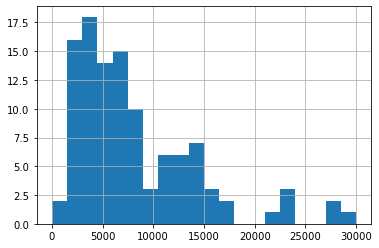

In [75]:
df_tpb_angles.angle_sum.hist(range=(0,30000), bins=20)

In [76]:
pb_lot_angles = Traffic.from_flights([f for f in tpb if angle(f)>10000])

In [79]:
pb_lot_angles.map_leaflet(zoom=14)

Map(center=[47.45799078906634, 8.555577611909483], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [213]:
traf['SWR18_13314'].pushback("LSZH").map_leaflet(zoom=13)

Map(center=[47.4662894347864, 8.545487691090967], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [39]:
dep_arr_df_2 = pd.read_pickle('../data/processed/dep_arr_df12_onehotconfig_addedsifis.pkl')

In [40]:
dep_arr_df_2.shape

(35530, 118)

In [81]:
tpb_5_11 = Traffic.from_flights([f.before(f.pushback('LSZH').stop).cumulative_distance() if f.pushback('LSZH') is not None else None for _,fid in dep_arr_df.query("first_movement_start.dt.day==5 & first_movement_start.dt.month==11 & end_pb==end_pb").iterrows() if ((f:=traf[fid.flight_id]) is not None) ]).clean_invalid()

/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)
/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/t

In [93]:
tpb_5_11.map_leaflet(zoom=13)

Map(center=[47.45763811150099, 8.555592230045217], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [83]:
#tpb = tpb.cumulative_distance().eval(desc="", max_workers=23)
tpb_dist_5_11_df = tpb_5_11.summary(['flight_id', 'cumdist_max'])

<AxesSubplot:>

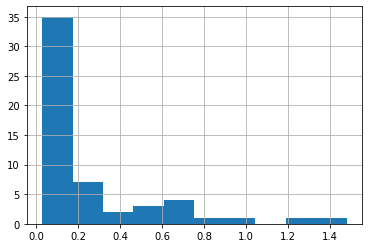

In [91]:
tpb_dist_5_11_df.cumdist_max.hist()

In [87]:
too_long_pb_5_11_traf = Traffic.from_flights([f for f in tpb_5_11 if f.cumdist_max>0.2])

In [88]:
too_long_pb_5_11_traf.map_leaflet(zoom=13)

Map(center=[47.457802088638736, 8.556376608210824], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [89]:
too_short_pb_5_11_traf = Traffic.from_flights([f for f in tpb_5_11 if f.cumdist_max<0.02])

In [90]:
too_short_pb_5_11_traf.map_leaflet(zoom=13)

AttributeError: 'NoneType' object has no attribute 'map_leaflet'

In [92]:
len(tpb_5_11)

55

# flight going half turn

In [6]:
import pandas as pd

In [7]:
pd.Timedelta("45s")

Timedelta('0 days 00:00:45')

In [12]:
from typing import (
    TYPE_CHECKING,
    Iterable,
    Iterator,
    List,
    Optional,
    Sequence,
    Union,
    cast,
)
from traffic.core.geodesy import destination, distance, mrr_diagonal
from traffic.core.iterator import flight_iterator
from traffic.core.time import deltalike, to_timedelta


import numpy as np
import pandas as pd
from shapely.geometry import LineString, MultiLineString, Point, Polygon

def slow_taxi(
    self,
    min_duration: deltalike = "60s",
    max_diameter: float = 150,  # in meters
) -> Iterator["Flight"]:
    """
    Holding segments are part of a trajectory where the aircraft stays more
    than min_duration (in s) within a circle of diameter max_diameter (in m)

    """
    self = cast("Flight", self)

    duration_threshold = pd.Timedelta('60s') #to_timedelta(min_duration)

    current_flight = self.moving()
    if current_flight is None:
        return None

    current_flight = current_flight.onground()
    if current_flight is None:
        return None

    current_flight = current_flight.resample("5s")
    if current_flight is None:
        return None

    traj_df = (
        current_flight.data[["timestamp", "latitude", "longitude"]]
        .sort_values("timestamp")
        .set_index("timestamp")
    )

    segment_geoms = []
    segment_times = []

    # Variables to detect changes between a stop
    # segment and a moving segment
    is_stopped = False
    previously_stopped = False

    # iterate over each coordinate to create segments
    # Each data point is added to a queue (FIFO)
    for index, row in traj_df.iterrows():
        segment_geoms.append(Point(row.longitude, row.latitude))
        segment_times.append(index)

        if not is_stopped:  # remove points to the specified min_duration
            while (
                len(segment_geoms) > 2
                and segment_times[-1] - segment_times[0]
                >= duration_threshold
            ):
                segment_geoms.pop(0)
                segment_times.pop(0)

        # Check if current segment, trimmed to have a duration shorthen than
        # min_duration threshold,  is longer than the maximum distance
        # threshold
        if (
            len(segment_geoms) > 1
            and mrr_diagonal(segment_geoms) < max_diameter
        ):
            is_stopped = True
        else:
            is_stopped = False

        # detection of the end of a stop segment and append to
        # stop segment list
        if len(segment_geoms) > 1:
            segment_end = segment_times[-2]
            segment_begin = segment_times[0]
            if not is_stopped and previously_stopped:
                if (
                    segment_end - segment_begin >= duration_threshold
                ):  # detected end of a stop
                    candidate = self.between(segment_begin, segment_end)
                    if candidate is not None:
                        yield candidate
                    segment_geoms = []
                    segment_times = []

        previously_stopped = is_stopped

    if (
        is_stopped
        and segment_times[-1] - segment_times[0] >= duration_threshold
    ):
        candidate = self.between(segment_times[0], segment_times[-1])
        if candidate is not None:
            yield candidate

In [16]:
dep_arr_df_14 = pd.read_pickle(
    "../data/processed/dep_arr_df14_nextavgdelaybetteraffected.pkl"
)


In [28]:
dep_arr_df_14.query("parking_position=='E58' & runway=='28' & mvt_type=='DEP'").sort_values('taxi_dist')

flight_id            on_runway_time taxi_holding_time  \
45123    BAW709_2470 2019-10-30 06:07:49+00:00   0 days 00:04:08   
15045   ASL29P_18753 2019-10-14 18:53:23+00:00   0 days 00:00:00   
78766     TAR701_059 2019-11-30 12:49:08+00:00   0 days 00:07:31   
53979   EIN3GC_18847 2019-11-07 09:34:30+00:00   0 days 00:00:00   
75237   ELY348_19745 2019-11-25 12:13:31+00:00   0 days 00:09:46   
...              ...                       ...               ...   
69202   EIN3GC_18833 2019-11-18 09:41:13+00:00   0 days 00:00:00   
72677   EIN3GC_18851 2019-11-22 09:48:31+00:00   0 days 00:07:35   
63584    EDW18Q_7919 2019-11-11 13:32:48+00:00   0 days 00:00:00   
64281   PGT948_18479 2019-11-12 11:05:02+00:00   0 days 00:01:18   
65089  GSW6028_15853 2019-11-13 17:11:27+00:00   0 days 00:10:23   

      rwy_holding_time total_holding_time  taxi_holding_time_minutes  \
45123             None    0 days 00:04:08                   4.133333   
15045             None    0 days 00:00:00                   0.000000   
78766             None    0 days 00:07:31                   7.516667   
53979             None    0 days 00:00:00                   0.000000   
75237             None    0 days 00:09:46                   9.766667   
...                ...                ...                        ...   
69202             None    0 days 00:04:25                   0.000000   
72677             None    0 days 00:08:15                   7.583333   
63584             None    0 days 00:03:28                   0.000000   
64281             None    0 days 00:06:26                   1.300000   
65089             None    0 days 00:13:34                  10.383333   

                 first_movement callsign registration typecode  ... runway_14  \
45123 2019-10-30 06:02:26+00:00   BAW709       G-EUPY     A319  ...         0   
15045 2019-10-14 18:49:41+00:00   ASL29P       YU-APH     A320  ...         0   
78766 2019-11-30 12:38:51+00:00   TAR701       TS-IMR     A320  ...         0   
53979 2019-11-07 09:31:11+00:00   EIN3GC       EI-DEF     A320  ...         0   
75237 2019-11-25 12:01:21+00:00   ELY348       4X-EKS     B738  ...         0   
...                         ...      ...          ...      ...  ...       ...   
69202 2019-11-18 09:32:09+00:00   EIN3GC       EI-DEB     A320  ...         0   
72677 2019-11-22 09:35:41+00:00   EIN3GC       EI-DEJ     A320  ...         0   
63584 2019-11-11 13:25:01+00:00   EDW18Q       HB-IJV     A320  ...         0   
64281 2019-11-12 10:52:46+00:00   PGT948       TC-NBI     A20N  ...         0   
65089 2019-11-13 16:50:46+00:00  GSW6028       HB-JOH     A319  ...         0   

      runway_16 runway_28 runway_32 runway_34  config_EAST config_NORTH0  \
45123         0         1         0         0            0             0   
15045         0         1         0         0            0             1   
78766         0         1         0         0            1             0   
53979         0         1         0         0            0             1   
75237         0         1         0         0            0             1   
...         ...       ...       ...       ...          ...           ...   
69202         0         1         0         0            0             1   
72677         0         1         0         0            0             1   
63584         0         1         0         0            0             1   
64281         0         1         0         0            0             1   
65089         0         1         0         0            0             1   

      config_NORTH1 config_SOUTH taxi_holding_time_minutes_cat  
45123             0            1                           1.0  
15045             0            0                           0.0  
78766             0            0                           1.0  
53979             0            0                           0.0  
75237             0            0                           2.0  
...             ...          ...                     

<AxesSubplot:>

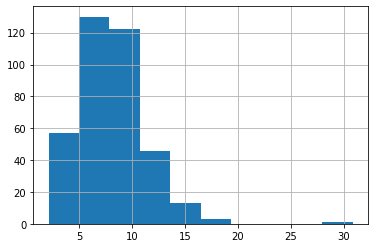

In [35]:
dep_arr_df_14.query("parking_position=='A17' & runway=='28' & mvt_type=='DEP'").sort_values('taxi_dist').real_dur_minutes.hist()

<AxesSubplot:>

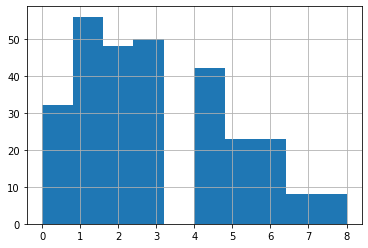

In [36]:
dep_arr_df_14.query("parking_position=='A17' & runway=='28' & mvt_type=='DEP'").sort_values('taxi_dist').sifi_DEP.hist()

In [39]:
dep_arr_df_14.query("parking_position=='A17' & runway=='28' & mvt_type=='DEP' & sifi_DEP<2").sort_values('taxi_dist').real_dur_minutes.describe()

count    88.000000
mean      7.176326
std       3.954895
min       2.116667
25%       4.700000
50%       6.625000
75%       8.258333
max      30.833333
Name: real_dur_minutes, dtype: float64

In [40]:
dep_arr_df_14.query("parking_position=='A17' & runway=='28' & mvt_type=='DEP' & sifi_DEP>=2").sort_values('taxi_dist').real_dur_minutes.describe()

count    202.000000
mean       8.364604
std        2.895024
min        2.466667
25%        6.600000
50%        8.175000
75%       10.033333
max       17.716667
Name: real_dur_minutes, dtype: float64

In [ ]:
A17    372
A57    336
E58    279
A13    261
A49    193

In [22]:
import types
f= traf['ACA879_20620']
f.slow_taxi = types.MethodType(slow_taxi, f)
m=f.first('30T').map_leaflet(zoom=13)
for seg in f.slow_taxi('LSZH'):
    m.add_layer(seg.leaflet(color='red'))
m

/home/service/miniconda3/envs/traffic2/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)


Map(center=[47.460499175982285, 8.55849229812622], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [29]:
f=traf['BAW709_2470']
f.map_leaflet()

/home/service/miniconda3/envs/traffic2/lib/python3.9/site-packages/traffic/core/flight.py:64: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  interpolated, *_ = data.astype(int).interpolate(*args, **kwargs)


Map(center=[47.45842861236075, 8.552460839852346], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [32]:
f=traf['ASL29P_18753']
f.map_leaflet(zoom=13)

Map(center=[47.44737353335608, 8.532105885756256], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [33]:
f.slow_taxi('LSZH').next()

ValueError: unit abbreviation w/o a number